# TUGAS BESAR KELOMPOK 15
# Deteksi Penyakit pada Daun Tomat Menggunakan Pendekatan Ekstraksi Ciri

## IMPORT LIBRARY

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from math import log
import math
import cv2
import pandas as pd
from math import ceil
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pada code diatas merupakan library library yang digunakan untuk mengerjakan project ini. seperti numppy untuk operasi perhitungan vektor, matplotlib untuk viasualiasi data, os untuk manipulasi folder, math untuk perhitungan matematika, cv2 untuk manipulasi gambar, pandas untuk manipulasi data, dan scikit-learn untuk analisis data.

## DISPLAY IMAGE

In [16]:
def tampilkanGambar(images, titles, row, col):
    plt.figure(figsize=(10,10))
    for i in range(row):
        for j in range (col):
            plt.subplot(row,col,i*col+(j+1))
            plt.grid(color="none")
            plt.imshow(images[i*col+j],'gray')
            plt.title(titles[i*col+j])
    plt.tight_layout()
    plt.show()

code diatas digunakan untuk menampilkan gambar. cara menggunakan fungsi ini adalah dengan menggunakan parameter image, titles, row, dan col. pada fungsi ini akan menampilkan sejumlah plot yang berukuran 10 x 10, gambar akan ditampilkan pada plot tersebut dengan grid yang sudah ditentukan.

In [17]:
def import_dataset(dataset_path, label_names):
    dataset = []
    labels = []
    limit=100
    
    for label_index, label_name in enumerate(label_names):
        label_path = os.path.join(dataset_path, label_name)
        image_files = os.listdir(label_path)[:limit]
        
        for image_file in image_files:
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path)
            
            if image is not None:
                dataset.append(image)
                labels.append(label_index)
   
    return dataset, labels

dataset_folder = 'dataset_tomat'
label_names = ['Bakteri', 'Penyakit', 'Sehat']
dataset, labels = import_dataset(dataset_folder, label_names)

pada code diatas adalah code untuk mengambil dataset yang digunakan. pada code ini akan mengambil dataset dari folder dataset_tomat yang ber-isikan beberapa sub folder yaitu bakteri, penyakit, dan sehat. pada setiap sub folder akan mengambil 100 image darinya kemudian melakukan proses import untuk bisa dieksekusi lebih lanjut pada program ini.

## NORMALISASI DAN RESIZE

In [18]:
def preprocess_dataset(data, labels):
    # Normalisasi
    image_size = (256, 256)
    normalized_data = []

    for image in data:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        # Resize
        image = cv2.resize(image, image_size)
        normalized_data.append(image)

    normalized_data = np.array(normalized_data, dtype='float32') / 255.0

    return normalized_data, labels

pada code diatas merupakan code untuk melakukan normalisasi pada data, lalu setelah melakukan normalisasi akan melakukan convert warna dari BGR ke GRAY dan setelah melakukan semua proses itu akan langsung di resize dengan ukuran 256 x 256. code ini merupakan langkash preprosessing awal yang digunakan dalam program ini

## FILTERING

In [19]:
def sorting(arr):
    for i in range(len(arr)):
        swap = i + np.argmin(arr[i:])
        (arr[i], arr[swap]) = (arr[swap], arr[i])
    return arr

pada code ini merupakan code untuk melakukan sorting dengan selection sort yang bertujuan untuk mengurutkan element element yang ada pada array lalu mengembalikan nilai dari array tersebut.

In [20]:
def flatArray(arr):
    row, col = arr.shape
    flat=[]
    for i in range (row):
        for j in range (col):
            flat.append(arr[i][j])
    return flat

pad code diatas merupakan code untuk melakukan fungsi mengubah array 2 dimensi menjadi array satu dimensi. dengan menggunakan fungsi ini akan menghasilkan array satu dimensi jika diberikan input berupa array dua dimensi


In [21]:
def median(image,windowHeight,windowWidth):
    pad = np.pad(image,(windowHeight,windowWidth),mode='edge')
    median = np.zeros(image.shape, dtype=np.uint8)
    for i in range(windowHeight,len(pad)-windowHeight):
        for j in range(windowWidth,len(pad)-windowWidth):
            window = flatArray(pad[i-windowHeight:i,j-windowWidth:j])
            window = sorting(window)
            median[i-windowHeight,j-windowWidth] = window[ceil(len(window)/2)]
    return median

pada code diatas merupakan code untuk melakukan fungsi filter median pada citra. pada filter median ini akan menggunakan kernel yang sesuai dengan kernel yang diinputkan sehingga pada code ini dapat leluasa mengganti jumlah kernel yang diinginkan jika dirasa filter belum maksimal kinerjanya.

## MORFOLOGI CITRA

In [22]:
def fit(window,SE): 
    for i in range(len(SE)):
      for j in range(len(SE)):
        if(SE[i][j]==1 and window[i][j]==0): 
          return 0
    return 1
def erosi(image,SE):
    erosi = np.zeros(image.shape, dtype=np.uint8)
    row, col = image.shape
    # melakukan perulangan pada window center image
    for i in range(row-len(SE)):
        for j in range(col-len(SE)):
            window = image[i:i+len(SE),j:j+len(SE)]
            # mengambil nilai pada fungsi fit, jika fit maka bernilai 1 jika tidak maka 0
            erosi[i][j] = fit(window,SE)
    return erosi

pada fungsi fit merupakan fungsi yang bertujuan untuk memeriksa apakah elementnya sesuai dengan element strukturalnya jika terdapat satu element yang tidak sesuai maka akan mengembalikan nilai 0. kemudian pada fungsi erosi merupakan fungsi untuk melakukan erosi yang bertujuan untuk menghilangkan piksel-piksel yang tidak relevan terhadap object suatu citra.

In [23]:
def convertBinary(image):
    ret, binary = cv2.threshold(image,30,255,cv2.THRESH_BINARY)
    return binary

pada code diatas merupakan code untuk convert gambar menjadi binary dengan memanfaatkan fungsi thresholding pada citra sehingga citra menjadi binary dengan nilai minimum 30 dan maksimum 255

In [24]:
def getParasite(image):
    ret,parasit = cv2.threshold(image,118,255,cv2.THRESH_BINARY)
    parasit-=255
    return parasit

pada code diatas merupakan code untuk convert gambar menjadi binary dengan memanfaatkan fungsi thresholding pada citra sehingga citra menjadi binary dengan nilai minimum 118 dan maksimum 255

In [25]:
SE = [[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]]

potongan code diatas merupakan struktur element dari program yang dibuat dan SE ini akan digunakan untuk pemrosesan pada program ini.

## SEGMENTASI CITRA

In [26]:
def segmentation(mainImage, grayImage):
    parasite=getParasite(grayImage)
    erode = erosi(parasite, SE)
    medParasite = median(erode, 4, 4)
    maskParasite = cv2.bitwise_and(mainImage, mainImage, mask=medParasite)
    return maskParasite

pada code diatas merupakan code untuk melakukan segmentasi. langkah-langkah untuk melakukan segmentasi pada fungsi tersebut yaitu parasite adalah treshoding dari 118 hingga 255, fungsi erosi, filtering median , dan yang terakhir adalah membuat mask untuk parasite. setelah semua program berjalan maka akan mengembalikan nilai dari mask parasite.

In [27]:
def drawParasite(mainImage, parasite):
    grayParasite = cv2.cvtColor(parasite, cv2.COLOR_RGB2GRAY)
    binaryParasite = convertBinary(grayParasite)
    contours, hierarchy = cv2.findContours(binaryParasite, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    parasiteDraw = cv2.drawContours(mainImage, contours, -1, (0,255,0), 2)
    return parasiteDraw

pada code diatas merupakn code untuk melakukan drawparasite. langkah-langkahnya adalah pertama melakukan convert BGR to Gray lalu melakukan tresholding pada citra yang telah di convert tersebut. kemudian melakukan findcontour yang berguna untuk untuk menemukan contur contur pada citra lalu menggambar kontur tersebut dengan warna yang telah ditentukan

In [28]:
dataset_dir = "dataset_tomat/"
images = []
labels = []
names = []

healthy = 1
bacterial_infection = 1
other_disease = 1

for sub_folder in os.listdir(dataset_dir):
    sub_folder_files = os.listdir(os.path.join(dataset_dir, sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img = cv2.imread(os.path.join(dataset_dir, sub_folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (255,255))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        if sub_folder == 'Sehat':
            segmented_dataset = segmentation(img, gray)
            draw = drawParasite(img, segmented_dataset)
            
            plt.imsave("segmented_dataset/Mask-" + sub_folder + "-" + str(healthy) + ".jpg", segmented_dataset)
            plt.imsave("raw_dataset/Draw-" + sub_folder + "-" + str(healthy) + ".jpg", draw)
            
            grayParasit = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            images.append(grayParasit)
            labels.append(sub_folder)
            names.append(filename)
            
            healthy += 1
        elif sub_folder == 'Bakteri':
            segmented_dataset = segmentation(img, gray)
            draw = drawParasite(img, segmented_dataset)
            
            plt.imsave("segmented_dataset/Mask-" + sub_folder + "-" + str(bacterial_infection) + ".jpg", segmented_dataset)
            plt.imsave("raw_dataset/Draw-" + sub_folder + "-" + str(bacterial_infection) + ".jpg", draw)
            
            grayParasit = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            images.append(grayParasit)
            labels.append(sub_folder)
            names.append(filename)
            
            bacterial_infection += 1
        else:
            segmented_dataset = segmentation(img, gray)
            draw = drawParasite(img, segmented_dataset)
            
            plt.imsave("segmented_dataset/Mask-" + sub_folder + "-" + str(other_disease) + ".jpg", segmented_dataset)
            plt.imsave("raw_dataset/Draw-" + sub_folder + "-" + str(other_disease) + ".jpg", draw)
            
            grayParasit = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            images.append(grayParasit)
            labels.append(sub_folder)
            names.append(filename)
            
            other_disease += 1

images = np.array(images)
labels = np.array(labels)
names = np.array(names)

Potongan kode yang diberikan merupakan bagian dari proses pengumpulan dataset untuk klasifikasi penyakit pada tanaman tomat. Kode ini membaca gambar-gambar dari direktori dataset yang terbagi menjadi beberapa subfolder yang mewakili kategori penyakit, yaitu 'Sehat', 'Bakteri', dan 'Lainnya'. Setiap gambar diubah ke dalam format RGB, kemudian diresize menjadi ukuran 255x255 piksel. Selanjutnya, gambar-gambar tersebut dikonversi menjadi skala keabuan (grayscale). Untuk setiap subfolder, dilakukan segmentasi gambar dan visualisasi dengan menggunakan fungsi segmentation dan drawParasite. Hasil segmentasi dan visualisasi tersebut disimpan dalam direktori segmented_dataset dan raw_dataset sesuai dengan kategori penyakit dan nomor indeks. Selain itu, citra dalam skala keabuan, label, dan nama gambar juga ditambahkan ke dalam array images, labels, dan names masing-masing. Setelah proses iterasi selesai, array images, labels, dan names diubah menjadi numpy array. Tujuan dari kode ini adalah untuk mempersiapkan dataset yang dapat digunakan dalam pelatihan model klasifikasi penyakit pada tanaman tomat.

## ERODE

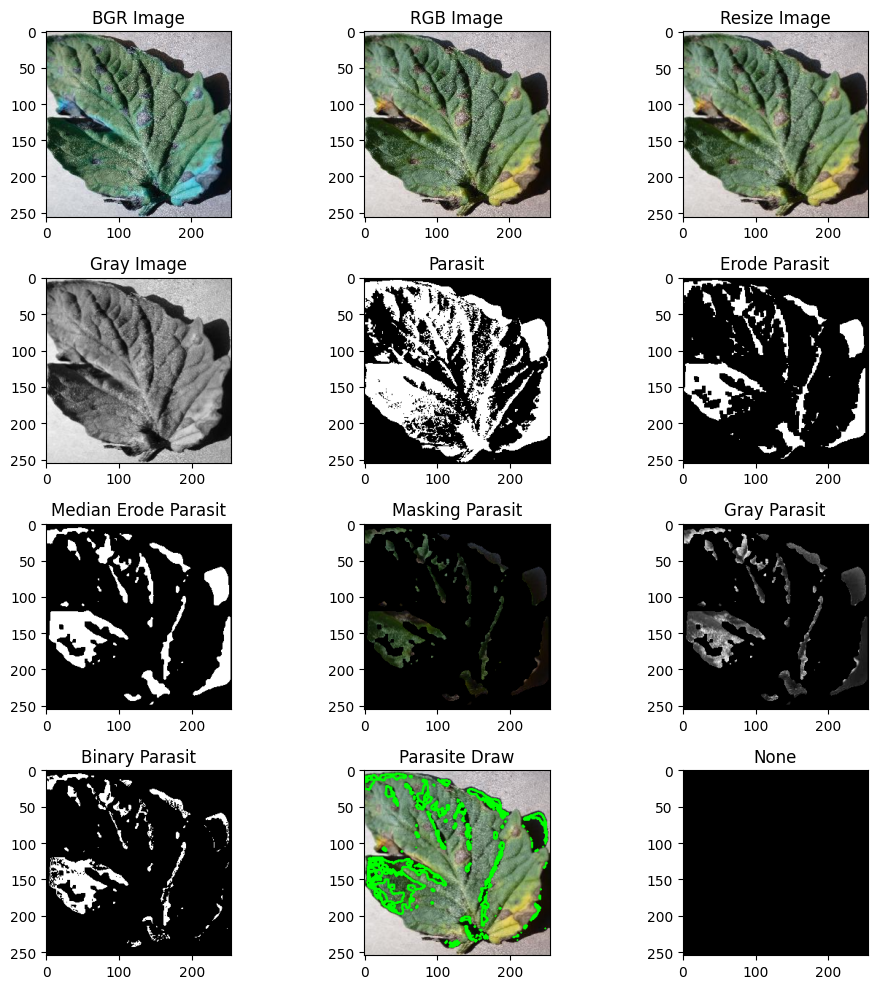

In [29]:
imgBGR = cv2.imread('dataset_tomat/Penyakit/1.JPG')
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
img = cv2.resize(imgRGB, (255,255))
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
parasite=getParasite(gray)
erode = erosi(parasite, SE)
medParasite = median(erode, 4, 4)
maskParasite = cv2.bitwise_and(img, img, mask=medParasite)
grayParasite = cv2.cvtColor(maskParasite, cv2.COLOR_RGB2GRAY)
binaryParasite = convertBinary(grayParasite)
contours, hierarchy = cv2.findContours(binaryParasite, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
parasiteDraw = cv2.drawContours(img, contours, -1, (0,255,0), 2)
none = np.zeros(img.shape)
img = cv2.resize(imgRGB, (255,255))
titles = ['BGR Image','RGB Image', 'Resize Image',
    'Gray Image', 'Parasit', 'Erode Parasit',
    'Median Erode Parasit', 'Masking Parasit', 'Gray Parasit',
    'Binary Parasit', 'Parasite Draw', 'None']
hasilimage = [imgBGR,imgRGB, img,
    gray, parasite, erode,
    medParasite, maskParasite, grayParasite,
    binaryParasite, parasiteDraw, none]
tampilkanGambar(hasilimage, titles, 4, 3)

Potongan kode tersebut merupakan proses pemrosesan gambar yang cukup kompleks. Dimulai dari membaca citra tomat dalam format BGR, konversi ke RGB, penyesuaian ukuran, konversi ke skala keabuan, segmentasi area parasit, operasi erosi, operasi median, masking dengan citra asli, konversi ke skala keabuan lagi, konversi ke citra biner, pencarian kontur, penggambaran kontur pada citra asli, hingga pembuatan citra kosong. Setiap langkah bertujuan untuk memperoleh area parasit yang tersegmentasi dengan baik dari citra asli, serta memvisualisasikan kontur pada citra asli. Potongan kode ini menggabungkan berbagai teknik pemrosesan gambar seperti konversi warna, segmentasi, operasi morfologi, dan analisis kontur untuk mencapai tujuan tersebut.

## GLCM

In [30]:
def transpose(matrix):
    matrix_transpose = []
    row,col = matrix.shape
    for i in range(row):
        mRow = []
        for j in range(col):
            mRow.append(matrix[j][i])
        matrix_transpose.append(mRow)
    return matrix_transpose

def dataSum(image):
    result = 0
    for i in range (len(image)):
        for j in range(len(image)):
            result+=image[i,j]
    return result

def normalization(image):
    row, col = image.shape
    n = dataSum(image)
    for i in range(row):
        for j in range(col):
            image[i,j]/=n
    return image

def cooccurance (image, dimention, degree):
    row, col = image.shape
    matrixCo = np.zeros([dimention+1,dimention+1])
    if(degree == 0):
        for i in range(row):
            for j in range(col):
                if(j+1 < col):
                    matrixCo[image[i,j], image[i,j+1]] += 1
    elif (degree == 45):
        for i in range(row):
            for j in range(col):
                if(i-1 >= 0 and j+1 < col):
                    matrixCo[image[i,j], image[i-1,j+1]] += 1
    elif (degree == 90):
        for i in range(row):
            for j in range(col):
                if(i+1 < row and j+1 < col):
                    matrixCo[image[i,j], image[i+1,j]] += 1
    elif (degree == 135):
        for i in range(row):
            for j in range(col):
                if(i+1 < row and j+1 < col):
                    matrixCo[image[i,j], image[i+1,j+1]] += 1
    trans = transpose(matrixCo)
    sumMatrix = matrixCo+trans
    glcm = normalization(sumMatrix)
    return glcm

Potongan kode tersebut mengimplementasikan beberapa fungsi terkait pemrosesan citra dengan menggunakan matriks ko-occurance. Fungsi `transpose` digunakan untuk mentransposisi matriks, yang kemudian digunakan dalam operasi ko-occurance. Fungsi `dataSum` menghitung jumlah nilai piksel pada citra. Fungsi `normalization` digunakan untuk normalisasi citra dengan membagi setiap piksel dengan jumlah total piksel. Fungsi `cooccurance` menghasilkan matriks ko-occurance berdasarkan arah yang ditentukan (0 derajat, 45 derajat, 90 derajat, atau 135 derajat). Setiap matriks ko-occurance dijumlahkan dengan matriks transposenya, kemudian dilakukan normalisasi. Hasil akhir adalah matriks ko-occurance yang mencerminkan hubungan spasial antara nilai piksel pada citra. Potongan kode ini menyediakan beberapa operasi dasar yang dapat digunakan dalam analisis citra dengan menggunakan matriks ko-occurance.

In [31]:
def mean(image):
    meanX=meanY= 0
    for i in range (len(image)):
        for j in range(len(image)):
            meanX += i * image[i,j]
            meanY += j * image[i,j]
    return meanX, meanY

def tao(image):
    taoX=taoY=0
    meanX,meanY= mean(image)
    for i in range (len(image)):
        for j in range(len(image)):
            taoX += pow((i-meanX),2)*image[i,j]
            taoY += pow((j-meanY),2)*image[i,j]
    return taoX, taoY

def extraction(image):
    energy=homogenity=entropy=contrast=disimilarity=correlation=ASM=0
    meanX, meanY = mean(image)
    taoX, taoY = tao(image)
    for i in range (len(image)):
        for j in range (len(image)):
            contrast += image[i,j]*pow((i-j),2)
            disimilarity += image[i,j]*abs(i-j)
            homogenity += image[i,j]/1+abs(i-j)
            if image[i,j] > 0:
                entropy += -(image[i,j] * log(image[i,j]))
            ASM += pow(image[i,j],2)
            correlation+=((i-meanX)*(j-meanY)*image[i,j])/pow((taoX*taoY),1/2)
    energy = pow(ASM, 1/2)
    return contrast,disimilarity,homogenity,entropy,ASM,energy,correlation

Potongan kode tersebut mengimplementasikan beberapa fungsi terkait ekstraksi fitur dari citra. Fungsi `mean` digunakan untuk menghitung rata-rata posisi piksel dalam citra, baik pada sumbu x maupun sumbu y. Fungsi `tao` digunakan untuk menghitung tao, yaitu variansi posisi piksel dalam citra, baik pada sumbu x maupun sumbu y, berdasarkan rata-rata yang telah dihitung sebelumnya. Fungsi `extraction` menghitung berbagai fitur ekstraksi citra seperti kontras, disimilitude, homogenitas, entropi, ASM (Angular Second Moment), energi, dan korelasi. Setiap fitur dihitung dengan menggunakan rumus-rumus matematis yang sesuai dengan definisi dari masing-masing fitur. Potongan kode ini menyediakan fungsi-fungsi yang dapat digunakan untuk mengambil informasi penting dari citra dan mewakili fitur-fitur tersebut dalam bentuk angka.

In [32]:
def getGLCM(images):
    glcmImage = []
    for i in range(len(images)):
        glcm = []
        max = images[i].max()
        glcm.append(cooccurance(images[i],max,0))
        glcm.append(cooccurance(images[i],max,45))
        glcm.append(cooccurance(images[i],max,90))
        glcm.append(cooccurance(images[i],max,135))
        glcmImage.append(glcm)
    return glcmImage
 
csv = []
index = 0
for i in getGLCM(images):
    extract = []
    extract.append(names[index])
    extract.append(labels[index])
    index+=1
    for img in i:
        contrast,disimilarity,homogenity,entropy,ASM,energy,correlation = extraction(img)
        extract.append(contrast)
        extract.append(disimilarity)
        extract.append(homogenity)
        extract.append(entropy)
        extract.append(ASM)
        extract.append(energy)
        extract.append(correlation)
    csv.append(extract)

Potongan kode tersebut merupakan bagian dari proses ekstraksi fitur menggunakan GLCM (Gray-Level Co-occurrence Matrix). Fungsi `getGLCM` digunakan untuk menghasilkan matriks GLCM dari kumpulan citra yang diberikan. Matriks GLCM ini dihasilkan dengan memanggil fungsi `cooccurance` untuk setiap citra dengan arah yang berbeda (0 derajat, 45 derajat, 90 derajat, 135 derajat). Setiap citra akan menghasilkan empat matriks GLCM yang berbeda, dan semua matriks GLCM ini disimpan dalam bentuk daftar. Selanjutnya, dilakukan ekstraksi fitur untuk setiap matriks GLCM yang dihasilkan. Fitur-fitur seperti kontras, disimilitude, homogenitas, entropi, ASM, energi, dan korelasi dihitung dengan menggunakan fungsi `extraction`. Setiap fitur yang dihitung untuk setiap citra akan ditambahkan ke dalam daftar `extract`. Akhirnya, semua daftar fitur yang dihasilkan akan disusun menjadi sebuah daftar yang berisi informasi fitur-fitur dari setiap citra. Potongan kode ini menghasilkan daftar fitur yang dapat digunakan untuk analisis lebih lanjut atau penyimpanan dalam format CSV.

In [33]:
headerTomat = ['Name','Label','Contrast0','Dissimilarity0','Homogenity0','Entropy0','ASM0','Energy0','Correlation0'
           ,'Contrast45','Dissimilarity45','Homogenity45','Entropy45','ASM45','Energy45','Correlation45'
           ,'Contrast90','Dissimilarity90','Homogenity90','Entropy90','ASM90','Energy90','Correlation90'
           ,'Contrast135','Dissimilarity135','Homogenity135','Entropy135','ASM135','Energy135','Correlation135']
df = pd.DataFrame(csv, columns=headerTomat)

Potongan kode tersebut menggunakan pustaka pandas untuk membuat sebuah DataFrame dari daftar fitur yang dihasilkan sebelumnya. Header kolom DataFrame disimpan dalam variabel `headerTomat`, yang mencakup nama-nama fitur seperti kontras, disimilitude, homogenitas, entropi, ASM, energi, dan korelasi dalam berbagai arah (0 derajat, 45 derajat, 90 derajat, 135 derajat). DataFrame dibuat dengan menggunakan fungsi `pd.DataFrame` dengan argumen `csv` yang berisi daftar fitur, dan argumen `columns` yang menggunakan header kolom yang telah ditentukan sebelumnya. DataFrame ini akan memuat informasi fitur dari setiap citra tomat, dengan setiap kolom mewakili sebuah fitur yang dihitung sebelumnya.

## HASIL

In [34]:
df.to_csv(r'hasiltomat.csv', index=False)

code diatas merupakan code untuk menyimpan dari dari program codingan yang telah dibuat sebelumnya dan menyimpannya kedalam bentuk file csv dengan judul hasiltomat.

In [35]:
df

,Name,Label,Contrast0,Dissimilarity0,Homogenity0,Entropy0,ASM0,Energy0,Correlation0,Contrast45,...,ASM90,Energy90,Correlation90,Contrast135,Dissimilarity135,Homogenity135,Entropy135,ASM135,Energy135,Correlation135
0,1.JPG,Bakteri,207.498549,5.929211,1.552433e+06,7.341932,0.008566,0.092551,0.929942,339.959560,...,0.008122,0.090122,0.918902,309.537061,8.008541,1.552433e+06,7.580236,0.007194,0.084815,0.895647
1,10.JPG,Bakteri,181.613355,7.748016,2.110481e+06,7.854296,0.007310,0.085497,0.916268,278.066991,...,0.007129,0.084432,0.908637,272.227695,10.219294,2.110481e+06,8.084798,0.005903,0.076830,0.874429
2,100.JPG,Bakteri,161.409850,5.296094,4.607921e+06,6.892244,0.011476,0.107128,0.874457,268.994342,...,0.011413,0.106830,0.858640,245.633285,7.247954,4.607921e+06,7.172345,0.009518,0.097562,0.808761
3,11.JPG,Bakteri,178.489393,7.418681,1.976521e+06,7.809972,0.005853,0.076504,0.919740,277.901637,...,0.005559,0.074556,0.908016,285.808094,9.782705,1.976521e+06,8.011826,0.004523,0.067255,0.871538
4,12.JPG,Bakteri,221.190088,6.451969,1.976521e+06,7.537952,0.004438,0.066618,0.934706,277.844736,...,0.004591,0.067755,0.941795,314.824338,8.523390,1.976521e+06,7.775189,0.003726,0.061043,0.907181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,95.JPG,Sehat,822.755550,19.750795,4.381341e+06,9.034569,0.001437,0.037909,0.748356,1027.810776,...,0.001406,0.037503,0.730508,1173.402691,23.932048,4.381341e+06,9.164760,0.001218,0.034901,0.642122
296,96.JPG,Sehat,262.940204,9.965648,3.086931e+06,7.853039,0.006394,0.079961,0.733927,360.814775,...,0.005889,0.076741,0.702489,394.015128,12.607291,3.086931e+06,8.014240,0.004907,0.070048,0.598319
297,97.JPG,Sehat,694.100417,19.135371,4.901961e+06,9.067950,0.001862,0.043145,0.731017,946.752217,...,0.001817,0.042629,0.721517,906.041788,22.277513,4.901961e+06,9.168282,0.001665,0.040807,0.648916
298,98.JPG,Sehat,672.946009,17.969847,4.493679e+06,8.925422,0.002219,0.047107,0.707667,964.724254,...,0.002282,0.047773,0.680687,913.249907,21.340148,4.493679e+06,9.047245,0.002020,0.044942,0.603363


code diatas merupakan code yang digunakan untuk menampilkan hasil dari data yang telah disimpan sebelumnya dan menampilkannya sesuai dengan header dan isi dari program yang sudah dibuat

In [46]:
y = df['Label']
X = df.drop(['Label', 'Name'], axis = 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=4)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25)

Potongan kode tersebut melakukan pemrosesan data dan persiapan dataset untuk pemodelan. Label atau target dari dataset diambil ke dalam variabel `y`, sedangkan dataset fitur diambil ke dalam variabel `X` setelah menghilangkan kolom 'Label' dan 'Name'. Fitur-fitur dalam `X` kemudian disesuaikan skala menggunakan `StandardScaler` untuk memastikan seragamnya skala antar-fitur. Selanjutnya, dilakukan reduksi dimensi dengan menggunakan Principal Component Analysis (PCA) untuk menghasilkan representasi fitur dengan dimensi yang lebih rendah dalam variabel `X_pca`. Selanjutnya, dataset dibagi menjadi data latih (`X_train` dan `y_train`) dan data uji (`X_test` dan `y_test`) dengan menggunakan `train_test_split`, yang memungkinkan penggunaan data latih untuk melatih model dan data uji untuk menguji performa model. Dengan langkah-langkah ini, dataset telah siap digunakan untuk pemodelan dan evaluasi lebih lanjut.

In [47]:
model = svm.SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Potongan kode tersebut menginisialisasi sebuah model Support Vector Machine (SVM) dengan menggunakan `svm.SVC()`. Model tersebut kemudian dilatih menggunakan data latih `X_train` dan `y_train` menggunakan metode `fit()`. Setelah melatih model, dilakukan prediksi pada data uji `X_test` menggunakan metode `predict()`, dan hasil prediksi disimpan dalam variabel `y_pred`. Dengan melakukan langkah-langkah tersebut, model SVM telah dilatih dan digunakan untuk melakukan prediksi pada data uji.

In [48]:
print("Accuracy:", round(accuracy_score(y_test, y_pred)*100),'%')

Accuracy: 87 %


Potongan kode tersebut mencetak akurasi hasil prediksi model dengan menggunakan fungsi `accuracy_score()` dari library scikit-learn. Nilai akurasi dihitung dengan membandingkan nilai aktual dari `y_test` (label yang sebenarnya) dengan nilai prediksi dari `y_pred`. Akurasi tersebut kemudian dibulatkan dan dicetak dalam bentuk persentase menggunakan fungsi `round()`. Dengan melakukan langkah ini, kita dapat melihat seberapa baik performa model SVM dalam memprediksi label pada data uji.

In [49]:
y_pred

array(['Bakteri', 'Penyakit', 'Bakteri', 'Penyakit', 'Bakteri',
       'Penyakit', 'Sehat', 'Bakteri', 'Bakteri', 'Sehat', 'Sehat',
       'Bakteri', 'Sehat', 'Penyakit', 'Bakteri', 'Bakteri', 'Sehat',
       'Sehat', 'Bakteri', 'Bakteri', 'Bakteri', 'Bakteri', 'Penyakit',
       'Bakteri', 'Sehat', 'Bakteri', 'Sehat', 'Penyakit', 'Bakteri',
       'Sehat', 'Penyakit', 'Bakteri', 'Sehat', 'Penyakit', 'Sehat',
       'Penyakit', 'Sehat', 'Sehat', 'Penyakit', 'Bakteri', 'Penyakit',
       'Bakteri', 'Bakteri', 'Penyakit', 'Sehat', 'Bakteri', 'Penyakit',
       'Penyakit', 'Bakteri', 'Bakteri', 'Sehat', 'Sehat', 'Penyakit',
       'Bakteri', 'Penyakit', 'Bakteri', 'Bakteri', 'Penyakit', 'Bakteri',
       'Penyakit', 'Bakteri', 'Bakteri', 'Bakteri', 'Penyakit', 'Sehat',
       'Bakteri', 'Bakteri', 'Bakteri', 'Penyakit', 'Penyakit',
       'Penyakit', 'Bakteri', 'Bakteri', 'Sehat', 'Bakteri'], dtype=object)

Variabel `y_pred` berisi hasil prediksi yang telah dilakukan oleh model SVM pada data uji (`X_test`). Hasil prediksi ini adalah label atau kelas yang diprediksi oleh model untuk setiap data dalam `X_test`.

In [50]:
y_test

130    Penyakit
157    Penyakit
97      Bakteri
146    Penyakit
7       Bakteri
         ...   
123    Penyakit
78      Bakteri
48      Bakteri
220       Sehat
56      Bakteri
Name: Label, Length: 75, dtype: object

Variabel `y_test` berisi label yang sebenarnya atau target yang sesungguhnya dari data uji. Ini digunakan sebagai pembanding untuk membandingkan dengan hasil prediksi yang dihasilkan oleh model SVM pada data uji (`y_pred`). Dengan membandingkan `y_test` dengan `y_pred`, kita dapat mengukur akurasi model dalam memprediksi dengan benar label-label yang sebenarnya.

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Bakteri       0.74      1.00      0.85        26
    Penyakit       0.95      0.72      0.82        29
       Sehat       1.00      0.90      0.95        20

    accuracy                           0.87        75
   macro avg       0.90      0.87      0.87        75
weighted avg       0.89      0.87      0.87        75



Potongan kode tersebut mencetak laporan klasifikasi dengan menggunakan fungsi `classification_report()` dari library scikit-learn. Laporan klasifikasi memberikan informasi yang lebih rinci tentang hasil prediksi model dengan membandingkan nilai aktual (`y_test`) dengan nilai prediksi (`y_pred`). Laporan ini mencakup metrik evaluasi seperti presisi (precision), recall, nilai F1 (F1-score), dan dukungan (support) untuk setiap kelas dalam masalah klasifikasi. Dengan mencetak laporan klasifikasi, kita dapat memahami performa model secara lebih rinci untuk setiap kelas dalam masalah klasifikasi.